# Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

In [3]:
!pip install skimpy
!pip install shap

In [4]:
#Основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as se
from skimpy import skim, clean_columns
import random

#Изученные модели из курса для классификации
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

#Вспомогательные функции
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import shap

#Метрики
from sklearn.metrics import mean_absolute_error, make_scorer

import warnings
warnings.filterwarnings("ignore")

In [5]:
#Настройка графиков
se.set_style('darkgrid')
#%config InlineBackend.figure_formats = 'png' # svg Не работает :(
se.set(rc={'font.size': 8, 
           'figure.facecolor': 'white',
           'figure.figsize': (12, 6),
           'axes.edgecolor': 'black',
           'axes.facecolor': 'white',
           'axes.grid': True,
           'grid.color': 'black',
           'grid.linewidth': 0.5,
           'grid.alpha': 0.3,
           'grid.linestyle': '--',
           'text.color': 'black',
           'xtick.color': 'black',
           'ytick.color': 'black',
           'font.size': 10.0,
           'xtick.bottom': True,
           'xtick.top': False,
           'ytick.left': True,
           'ytick.right': True,
           'lines.linewidth': 1, 
           'patch.edgecolor': 'w',
           'lines.solid_capstyle': 'butt',
           'patch.linewidth': 0.2})

In [6]:
try:
    data_arc = pd.read_csv("/datasets/final_steel/data_arc.csv")
    data_bulk = pd.read_csv("/datasets/final_steel/data_bulk.csv")
    data_bulk_time = pd.read_csv("/datasets/final_steel/data_bulk_time.csv")
    data_gas = pd.read_csv("/datasets/final_steel/data_gas.csv")
    data_temp = pd.read_csv("/datasets/final_steel/data_temp.csv")
    data_wire = pd.read_csv("/datasets/final_steel/data_wire.csv")
    data_wire_time = pd.read_csv("/datasets/final_steel/data_wire_time.csv")
except:
    data_arc = pd.read_csv("C:\\Users\\Professional\\Desktop\\DataSet\\final_steel\\data_arc.csv")
    data_bulk = pd.read_csv("C:\\Users\\Professional\\Desktop\\DataSet\\final_steel\\data_bulk.csv")
    data_bulk_time = pd.read_csv("C:\\Users\\Professional\\Desktop\\DataSet\\final_steel\\data_bulk_time.csv")
    data_gas = pd.read_csv("C:\\Users\\Professional\\Desktop\\DataSet\\final_steel\\data_gas.csv")
    data_temp = pd.read_csv("C:\\Users\\Professional\\Desktop\\DataSet\\final_steel\\data_temp.csv")
    data_wire = pd.read_csv("C:\\Users\\Professional\\Desktop\\DataSet\\final_steel\\data_wire.csv")
    data_wire_time = pd.read_csv("C:\\Users\\Professional\\Desktop\\DataSet\\final_steel\\data_wire_time.csv")

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Знакомство с данными

In [7]:
def tinder_data(data):
    display(data.head())
    print(skim(data))
    print('-'*120)
    print('-'*120)

In [8]:
tinder_data(data_arc)

In [9]:
tinder_data(data_bulk)

In [10]:
tinder_data(data_bulk_time)

In [11]:
tinder_data(data_gas)

In [12]:
tinder_data(data_temp)

In [13]:
tinder_data(data_wire)

In [14]:
tinder_data(data_wire_time)

### Выводы

На первый взгляд ничего непонятно. Необходим более детальный подход к каждомуц набору данных. Первое что бросается в галаз это названия столбцов и неверные типы данных. 

## Предварительная обработка данных

### Изменение названий столбцов

In [15]:
data_arc.rename(columns ={'Начало нагрева дугой' : 'heating_start',  'Конец нагрева дугой': 'heating_end', 
                          'Активная мощность': 'active_power','Реактивная мощность': 'reactive_power'}, inplace=True)

In [16]:
data_gas.rename(columns = {'Газ 1': 'gas_1'}, inplace=True)

In [17]:
data_temp.rename(columns = {'Время замера': 'measure_time',  'Температура': 'temperature'}, inplace=True)

In [18]:
data_bulk = clean_columns(data_bulk)
data_bulk_time = clean_columns(data_bulk_time)
data_wire = clean_columns(data_wire)
data_wire_time = clean_columns(data_wire_time)

In [19]:
print(*data_arc.columns)
print(*data_bulk.columns)
print(*data_bulk_time.columns)
print(*data_gas.columns)
print(*data_temp.columns)
print(*data_wire.columns)
print(*data_wire_time.columns)

### Приведение к нужному типу данных

In [20]:
data_arc['heating_start'] = pd.to_datetime(data_arc['heating_start'], format='%Y-%m-%dT%H:%M:%S')
data_arc['heating_end'] = pd.to_datetime(data_arc['heating_end'], format='%Y-%m-%dT%H:%M:%S')

In [21]:
data_temp['measure_time'] = pd.to_datetime(data_temp['measure_time'], format='%Y-%m-%dT%H:%M:%S', errors='ignore')

In [22]:
for wire in data_wire_time.columns:
    if wire != 'key':
        data_wire_time[wire] = pd.to_datetime(data_wire_time[wire], format='%Y-%m-%dT%H:%M:%S')

In [23]:
print(data_arc.info())
print('-'*100)
print(data_temp.info())
print('-'*100)
print(data_wire_time.info())
print('-'*100)

### План проекта

1) Анализ данных - поиск пропусков, замена NaN, приведение данных к финальному виду (c одним  key в таблице), таких как данные об электродах. Получение первой и последней температур. Также расчет полной мощности нагрева одной партии и работы по формулам:

$$
 P_{total} = \sqrt {P_{active}^2 + P_{reactive}^2}
$$

$$
A = P_{total} * t
$$

2) Объединение таблиц в одну, выделение целевого признака и анализ на мультиколлинеарность.

3) Построение нескольких моделей и тестирование 

4) Вывод




##План проекта  
**1. Проведение обзора данных (EDA)**

**Подготовка данных:** 
* Импорт необходимых библиотек;
* Чтение файлов и сохранение полученных данных в переменные;
* Получение общей информации о таблицах (head, info, describe);
* Корректировка наименований столбцов (при необходимости).
* Выводы

**Анализ данных:**
* Графическое представление данных из таблиц;
* Проверка данных на аномалии.
* Выводы

**Предобработка данных:**
* Корректировка типов данных (при необходимости);
* Заполнение пропусков / удаление дубликатов (при наличии);
* Выделение признаков и таргета;
* Соединение таблиц.
* Выводы

**Исследование итоговой таблицы с данными:**
* Аналитический анализ
* графический анализ
* корреляционный анализ
* выводы

**2. Построение модели машинного обучения**

**Обучение модели:**
* Разделение данных на обучающую и тестовую выборки;
* Масштабирование данных;
* Обучение модели линейной регрессии;
* Обучение модели градиентного бустинга с перебором гиперпараметров;
* Константная модели.
* Выбор лучшей модели

**Проверка моделей:**
* Тестирование лучшей модели на тестовой выборке;
* Если MAE на тестовых данных > 6.8 - доработка модели.
* Анализ важности факторов

**3. Общий вывод**

# Анализ данных

В данном пункте я пройдусь по всем данным, посмотрю на особенности и зависимости, поищу возможные выбросы. Также подготовлю данные для объединения.

## Данные об электродах

In [24]:
data_arc['key'].value_counts()

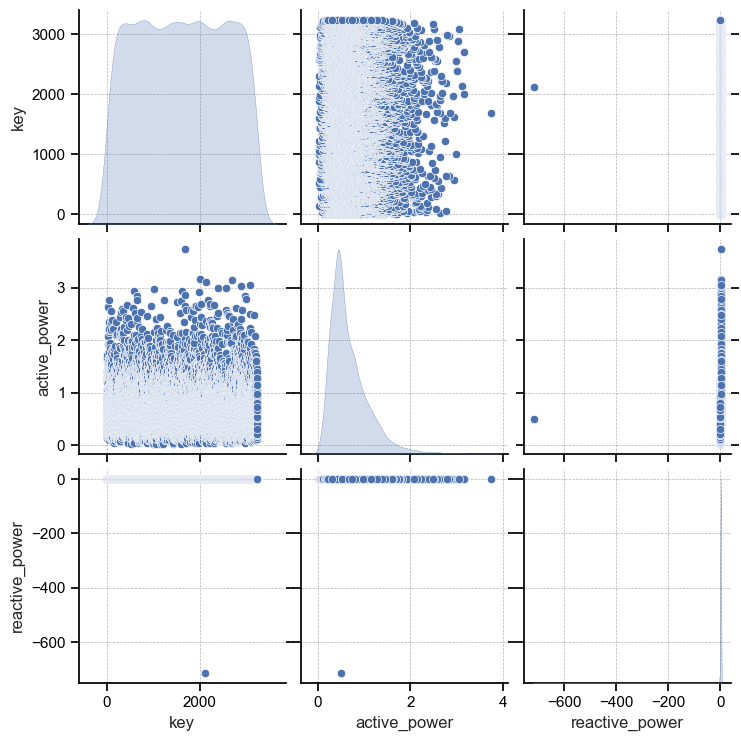

In [25]:
se.pairplot(data_arc,  diag_kind='kde', palette='colorblind')
plt.show()

Видно, что есть сильный выброс. Удалим его

In [26]:
data_arc = data_arc.query('reactive_power > -600')

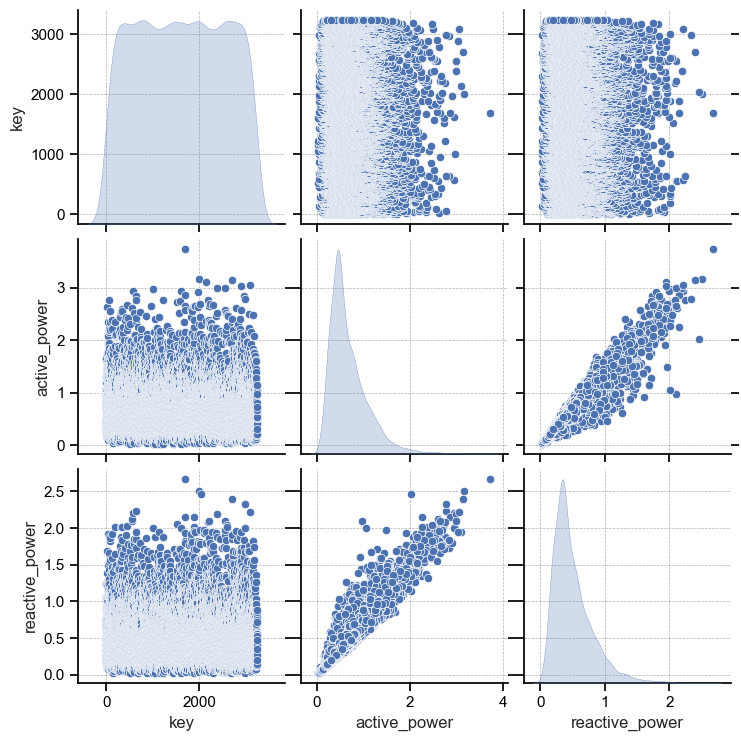

In [27]:
se.pairplot(data_arc,  diag_kind='kde', palette='colorblind')
plt.show()

Теперь распределения выглядят логнормально))

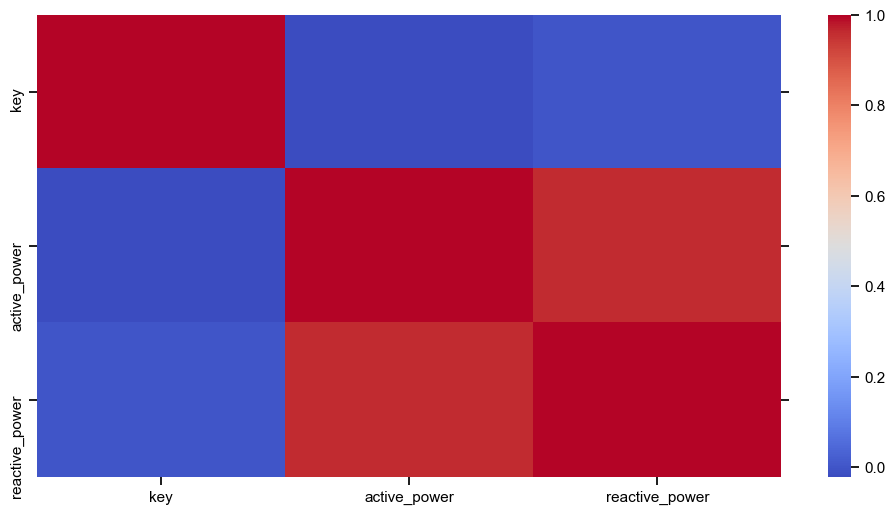

In [28]:
print("Корреляция параметров между собой")
se.heatmap(data_arc.corr(), cmap='coolwarm')

Видно, что мощности корелируют между собой

Теперь рассчитаем необходимые данные. Нам нужна полная работа, так как она содержит данные о времени нагрева, что очень важно, те полная мощность умноженная на время. Так же все единицы нужны нам системе СИ, поэтому будем брать секунды. 

In [29]:
data_arc['total_power'] = data_arc.apply(lambda x: (x['active_power']**2 + x['reactive_power']**2)**0.5, axis=1)

In [30]:
data_arc['total_time'] = (data_arc['heating_end'] - data_arc['heating_start']).dt.seconds

In [31]:
data_arc['operation'] = data_arc.apply(lambda x: x['total_power'] * x['total_time'], axis=1)

In [32]:
data_arc

In [33]:
data_arc_final = data_arc.groupby('key').sum()[['total_power', 'operation']]
data_arc_final

### Вывод

Исследовали данные на наличие выбросов, корреляцию и рассчитали необходимые параметры. 

## Данные о подаче сыпучих материалов (объём)

In [34]:
data_bulk

Очевидно, что пропуски здесь, это не ошибка данных, а показатель, что этот материла не учавствовал в процессе для данной партии. Поэтому самое логичное заполнить их нулями. Но после анализа на выбросы

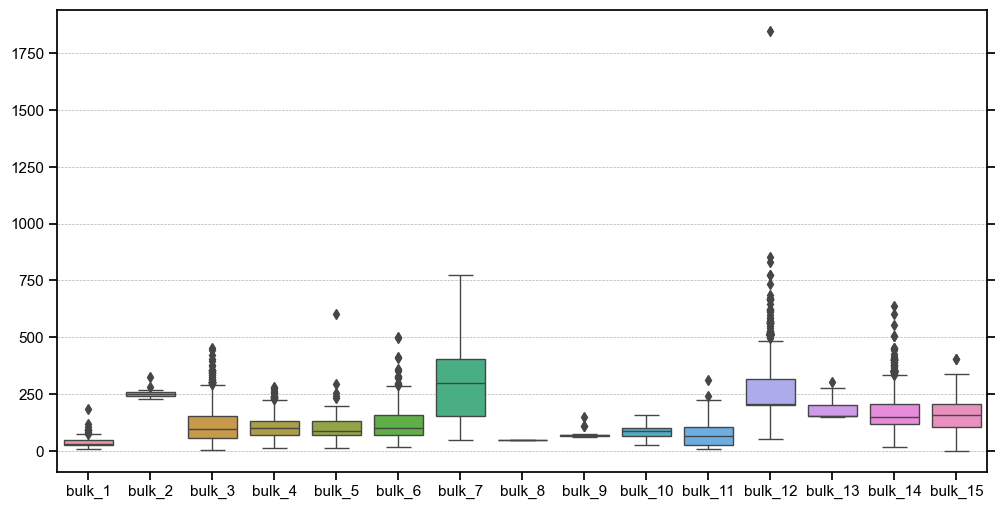

In [35]:
se.boxplot(data=data_bulk.drop(columns=['key']))

Единичное значение объема материала под номером 12 похож на выброс. Долой его

In [36]:
data_bulk = data_bulk.query('bulk_12 < 1750')

In [37]:
data_bulk.fillna(0, inplace=True)
data_bulk.set_index('key', inplace=True, drop=True)

In [38]:
data_bulk.head()

### Вывод

Удалили один выброс, занулил пропуски и сделали индексацию по номеру партии.

## Данные о проволочных материалах (объём)

Аналогично предыдущему пункту. 

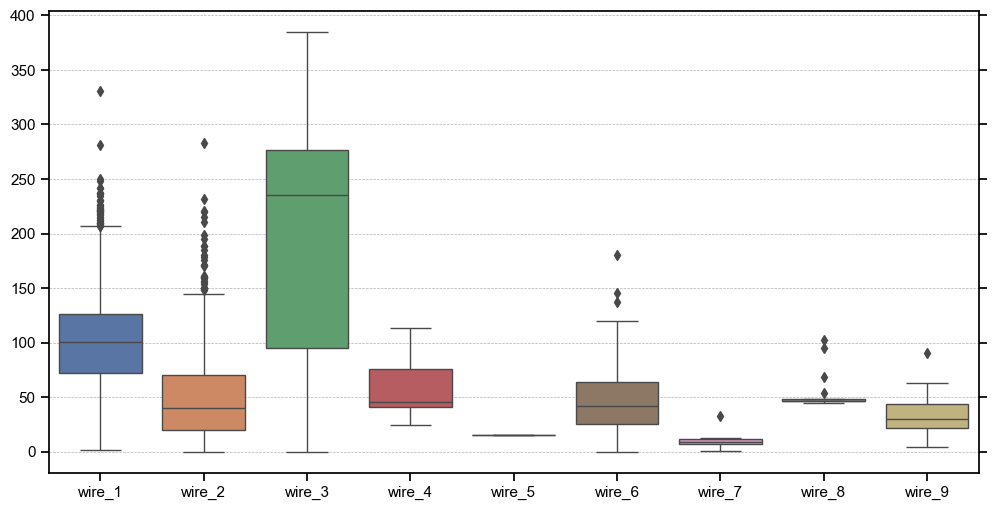

In [39]:
se.boxplot(data=data_wire.drop(columns=['key']))

In [40]:
data_wire.fillna(0, inplace=True)
data_wire.set_index('key', inplace=True, drop=True)

In [41]:
data_wire

## Результаты измерения температуры

In [42]:
data_temp

In [43]:
last_time_group = data_temp.groupby('key').agg(['max'])['measure_time']['max']

In [44]:
last_time = data_temp.query('measure_time in @last_time_group')
last_time.set_index('key', drop=True, inplace=True)
last_time.rename(columns={'temperature': 'temperature_end', 'measure_time': 'last_measure_time'}, inplace=True)

In [45]:
last_time.isna().sum()

In [46]:
first_time_group = data_temp.groupby('key').agg(['min'])['measure_time']['min']
first_time = data_temp.query('measure_time in @first_time_group')
first_time.set_index('key', drop=True, inplace=True)
first_time.rename(columns={'temperature': 'temperature_start', 'measure_time': 'first_measure_time'}, inplace=True)
first_time.isna().sum()

In [47]:
data_temp_final = pd.concat([first_time, last_time], join='inner', axis=1)
data_temp_final

### Вывод 

столбец temperature_end - целевая температура, а temperature_start- начальная температура сплава

## Данные о продувке сплава газом

In [48]:
data_gas.set_index('key', drop=True, inplace=True)

### Вывод 

Сделал индексом партии

# Подготовка данных

## Объединение данных

In [49]:
final_data = pd.concat([data_arc_final, data_bulk, data_wire, data_temp_final[['temperature_start', 'temperature_end']], data_gas], axis=1)

In [50]:
final_data

Удалим строки, где нет целевого признака.

In [51]:
final_data = final_data.loc[~final_data['temperature_end'].isna()]

In [52]:
final_data.isna().sum()

Заполним пропуски нулями/заглушкой

In [53]:
final_data.fillna(0, inplace= True)
final_data

## Анализ финального набора данных

In [54]:
final_data.describe()

In [55]:
final_data.drop(columns=['bulk_2', 'bulk_8', 'wire_4', 'wire_5','wire_7'], inplace=True)

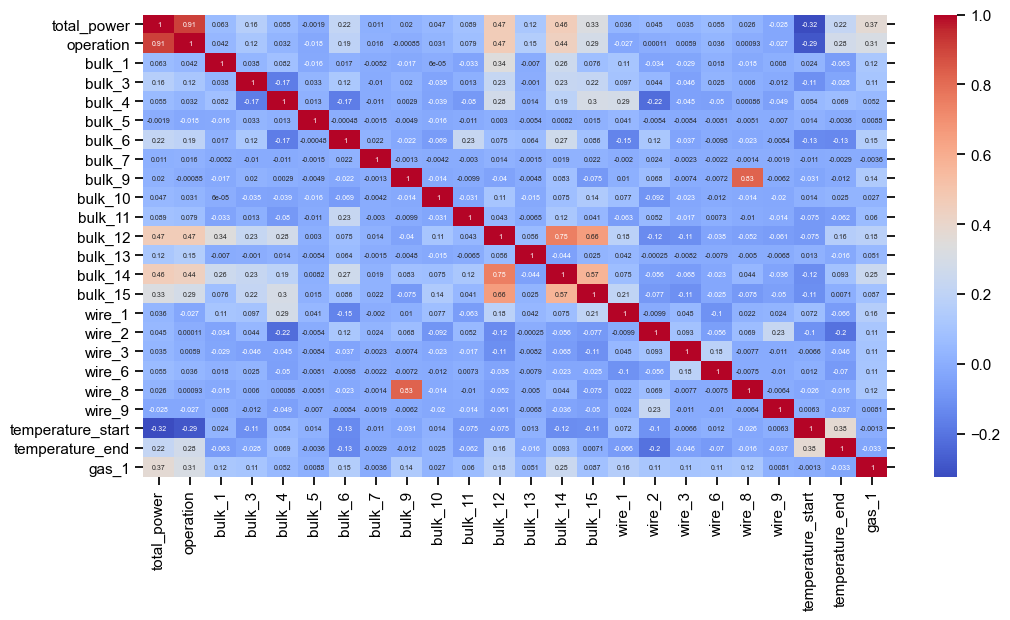

In [56]:
print("Корреляция параметров между собой")
se.heatmap(final_data.corr(), cmap='coolwarm', annot=True, annot_kws={"size": 5})

Видно, что есть параметры, которые сильно коррелируют между собой. Почистим от них данные. 

In [57]:
final_data.drop(columns=['wire_8', 'bulk_12', 'bulk_14', 'total_power'], inplace=True)

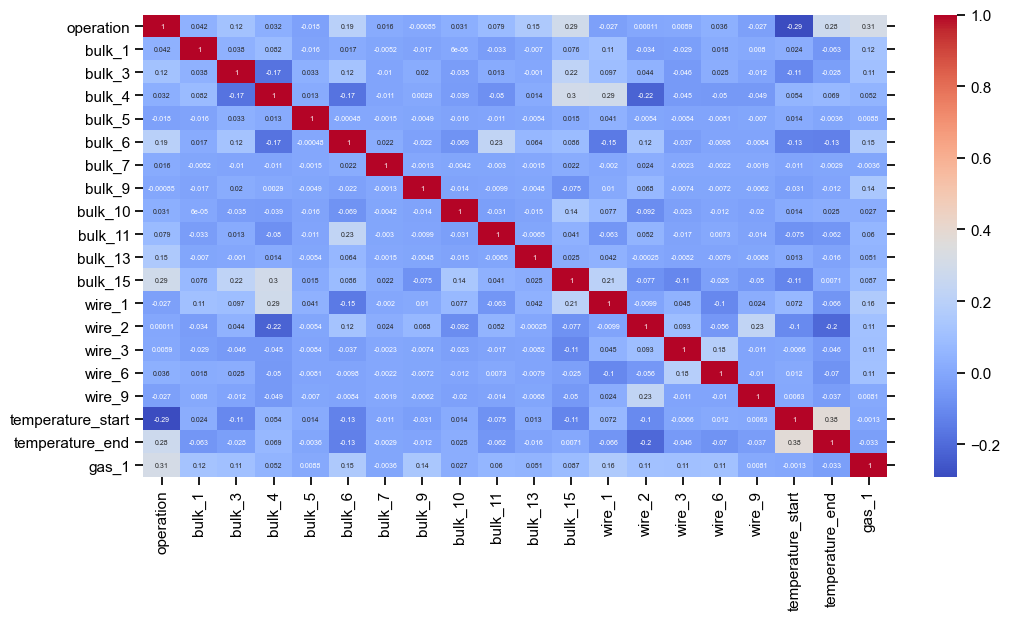

In [58]:
print("Корреляция параметров между собой")
se.heatmap(final_data.corr(), cmap='coolwarm', annot=True, annot_kws={"size": 5})

## Подготовка данных к обучению

In [59]:
#константы
RANDOM_STATE = 7042023

In [60]:
target = final_data['temperature_end']
features = final_data.drop(columns=['temperature_end'])

In [61]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, test_size=0.25, random_state=RANDOM_STATE)

In [62]:
print(features_train.shape)
print(target_train.shape)

In [63]:
print(features_test.shape)
print(target_test.shape)

# Построение модели


In [64]:
all_models = dict()

## Линейная регрессия

In [65]:
pipeline = Pipeline([('scale', StandardScaler()),
    ('lin_reg', LinearRegression())])

cv_MAE_LR = abs(round(np.mean(cross_val_score(pipeline, features_train,  target_train, cv=4, scoring='neg_mean_absolute_error')), 3))
print('MAE =', cv_MAE_LR)

In [66]:
LR_model = pipeline.fit(features_train,  target_train)

In [67]:
all_models['LinearRegression'] = [LR_model, cv_MAE_LR]

## Случайный лес

In [76]:
%%script false

#%%time

regressor = RandomForestRegressor(random_state=RANDOM_STATE) 
params = {'n_estimators':[x for x in range(50, 601, 50)], 'max_depth':[2,4,6,8, 10]}

RF_reg = GridSearchCV(regressor, params, scoring='neg_mean_absolute_error', cv=4, n_jobs=-1)
RF_reg.fit(features_train,  target_train)

print("Параметры лучшей модели", RF_reg.best_params_)
print("MAE = ", round(abs(RF_reg.best_score_), 3))

all_models['RandomForestRegressor'] = [RF_reg, round(abs(RF_reg.best_score_), 3)]

## CatBoost

In [69]:
%%time

regressor = CatBoostRegressor(random_state = RANDOM_STATE, verbose = False)
params = {'depth': [6,8,10],
                  'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
                  'iterations': [30, 50, 100, 150]}
CB_reg = GridSearchCV(estimator=regressor, param_grid = params, cv = 4, n_jobs=-1, scoring='neg_mean_absolute_error')
CB_reg.fit(features_train,  target_train) 

print("Параметры лучшей модели", CB_reg.best_params_)
print("MAE = ", round(abs(CB_reg.best_score_), 3))

all_models['CatBoostRegressor'] = [CB_reg, round(abs(CB_reg.best_score_), 3)]

## LGBMRegressor

In [77]:
%%script false

#%%time

regressor = LGBMRegressor(random_state = RANDOM_STATE) 
params = {'num_leaves':[x for x in range(4,31)], 
                'learning_rate':[x/100 for x in range(1, 11)]}

LGBMR = GridSearchCV(regressor, params, scoring='neg_mean_absolute_error', cv=4, n_jobs=-1)
LGBMR.fit(features_train,  target_train)

print("Параметры лучшей модели", LGBMR.best_params_)
print("MAE = ", round(abs(LGBMR.best_score_), 3))

all_models['LGBMRegressor'] = [LGBMR, round(abs(LGBMR.best_score_), 3)]

## Итог обучения

In [78]:
for model, values in all_models.items():
    print(f'MAE модели {model} = {values[1]}')

Лучший результат обучения показала модель catboost со значением метрики MAE = 6.454. Возможно если не выбрасывать сильно коррелирующие параметры и исключить из датасета данные с "заглушками", то результат был бы выше. Но для поставленной задачи данного подхода достаточно. 

## Тестирование лучшей модели модели

In [72]:
print(f'MAE модели CatBoostRegressor не тестовых данных = {round(mean_absolute_error(all_models["CatBoostRegressor"][0].predict(features_test), target_test), 3)}')

## Главные компоненты shap

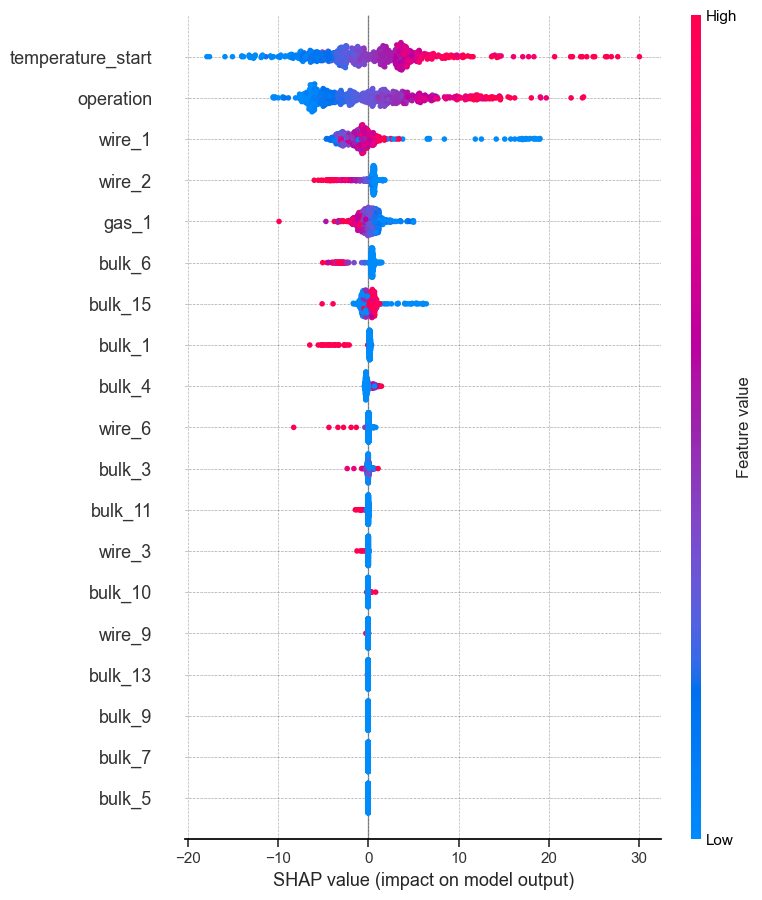

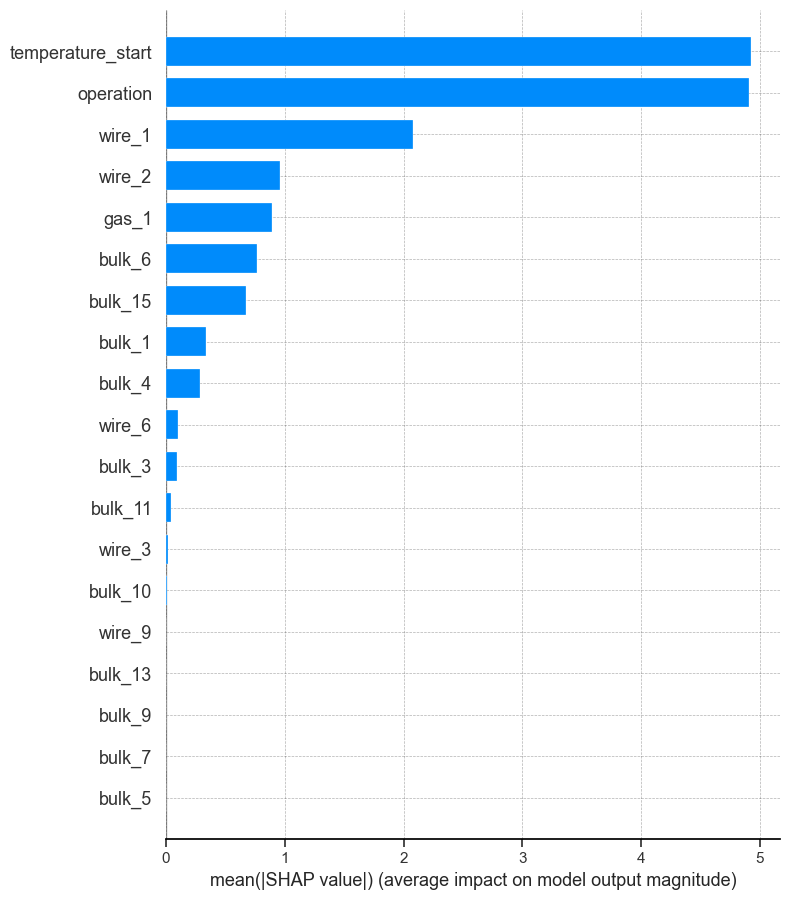

In [73]:
shap_test = shap.TreeExplainer(all_models["CatBoostRegressor"][0].best_estimator_).shap_values(features_test)
shap.summary_plot(shap_test, features_test, auto_size_plot=True)

shap.summary_plot(shap_test, features_test, plot_type="bar")

Самыми значимыми параметрами для модели являются работа и начальная температура. А также некоторые прекурсоры (wire_1/_2/_6, bulk_1/_4) и газ.

## Вывод

Было обучено 4 модели:

    1) Линейная регрессия  
    2) Случайный лес  
    3) CatBoost  
    4) LGBM  
Лучший результат на кросс-валидации показала модель **CatBoost** со значение метрики MAE = 6.213 на тестовой выборки, что удовлетворяет условию задачи. Возможно, если из датасета исключить данные, в которых был поставлены заглушки вместо пропусков, то результат будет намного лучше. 


# Отчёт

Работа была выполнена в соответствии с планом: 

1. Импортированные данные были предварительно обработаны, изменены названия признаков в соответствии со "змеиным стилем", изменены типы данных. Для знакомства с данными использовалась библиотека skimpy. 
2. Проделан анализ данных, построены матрица рассеяния и "ящик с усами" для поиска очевидных выбросов. Рассчитаны новый признак - работа, которая была проделана электродами над сплавами и суммарная мощность. Рассчитан целевой признак. Пропуски были заполнены нулями.
3. Собран итоговый набор данных. В него не вошли данные связанные со временем добавления прекурсоров. Было выявлено много данных, в которых нет конечной температуры. Они были удалены. Пропуски в остальных данных, были заполненны заглушками. Корреляция параметров в финальном датасете показала зависимость параметров 'wire_8', 'bulk_12', 'bulk_14', 'total_power' с остальными и они были удалены. Таблица итоговой корреляция представлена ниже

Корреляция параметров между собой:
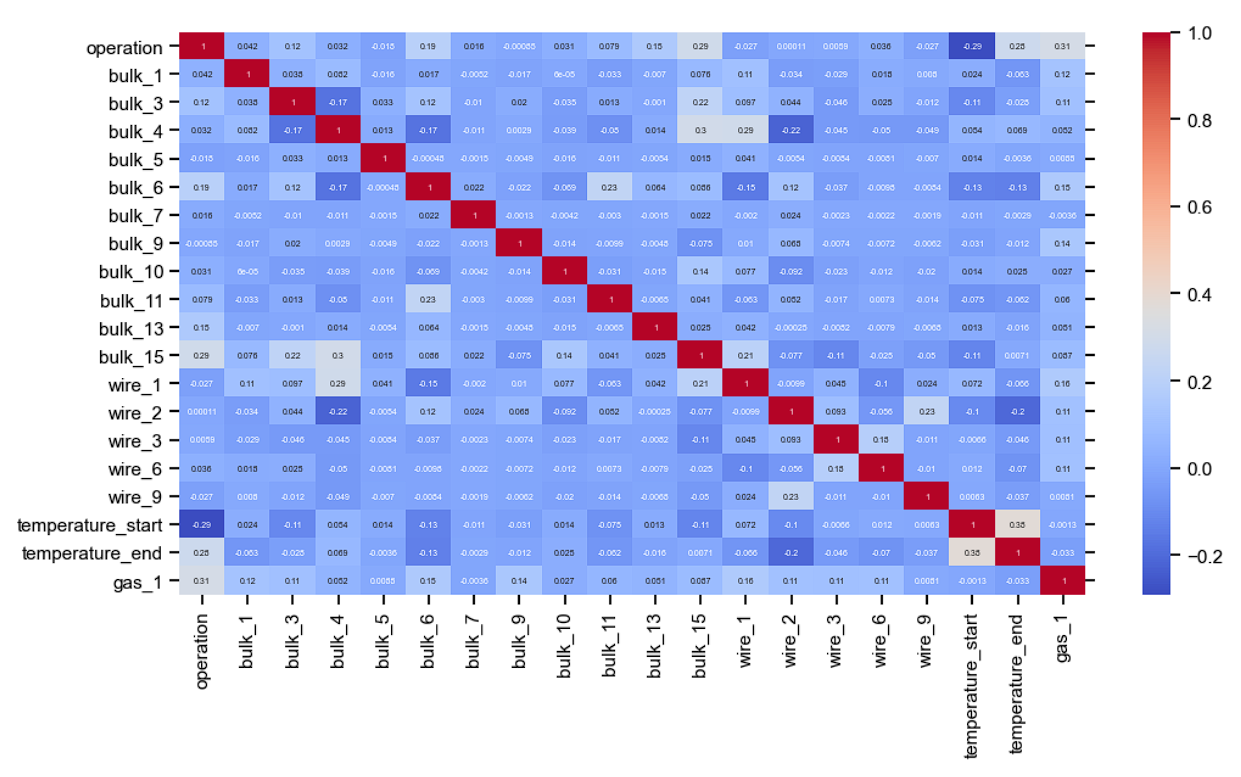

4) Было построено 4 разные модели:

    а) Линейная регрессия (MAE = 8.261)
    б) Случайный лес  (MAE = 6.626)
    в) CatBoost  (MAE = 6.454)
    г) LGBM  (MAE = 6.593)  
(Значения метрики MAE получены на кросс-валидации на тренировочной выборке).  
Все кроме линейной регрессии показали хороший результат на кросс-валидации. Лучше моделью оказалась CatBoost. На тестовой выборке она показала значение MAE = 6.213, что удовлетворяет условию задачи. Анализ клавных компонент модели показал доминирование следующих признаков: *temperature_start, operation, wire_1, wire_2, gas_1, bulk_6, bulk_15, bulk_1 и bulk_4*. Остальные признаки оказывают меньшее влияние на результат.  
Трудностей в выполнении работы не было.  

В итоговом датасете остались признаки: operation, bulk_1, bulk_3, bulk_4, bulk_5, bulk_6, bulk_7, bulk_9, bulk_10, bulk_11, 
bulk_13, bulk_15, wire_1, wire_2, wire_3, wire_6, wire_9, temperature_start, temperature_end, gas_1

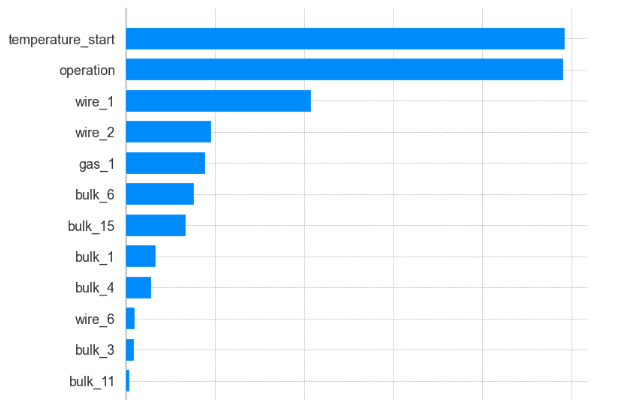

Анализ важности этих признаков представлен выше.

Лучшая модель - Cat_Boost c параметрами:   
 - depth - 8
 - iterations - 150
 - learning_rate - 0.05
 - random_sstate -  7042023

В качестве рекомендаций могу порекомендовать чаще снимать температуру в котле. В большом количестве данных были пропуски. Также температуру лучше снимать в нескольких местах одновременно, чтобы понимать её распределение и градиент. также всегда можно будет взять среднее, если какие-то из данных будут потерянны. Нам интересно её изменение после каждого этапа обработки, ведь поведение может быть разным.